In [83]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)







C:\Users\Nayamat\AppData\Local\Temp\ipykernel_10660\951815184.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

Data fetched from 2015-07-12 to 2025-07-11
Price            Close        RSI
Ticker            AAPL           
Date                             
2025-07-07  209.949997  72.666220
2025-07-08  210.009995  70.792964
2025-07-09  211.139999  79.557588
2025-07-10  212.410004  79.811676
2025-07-11  211.160004  71.727976


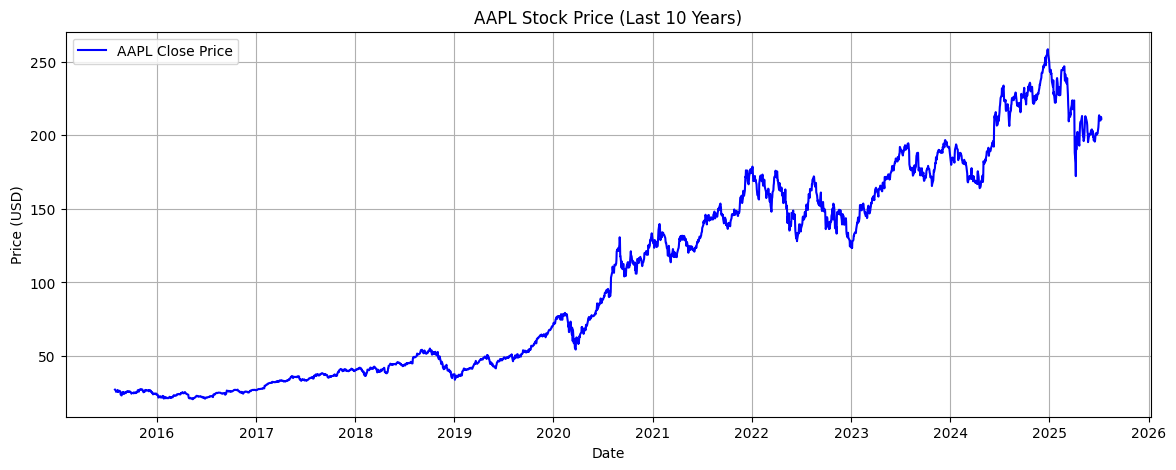

In [ ]:
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

# Fetch data
ticker = "AAPL"
start_date = (datetime.now() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_date)
data = data[['Close']] 

# Compute RSI
data = compute_RSI(data)

# Drop rows with NaN (from RSI calculation)
data.dropna(inplace=True)

# Show range and recent data
print(f"Data fetched from {start_date} to {data.index[-1].strftime('%Y-%m-%d')}")
print(data.tail())

# Plot Close price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='AAPL Close Price', color='blue')
plt.title('AAPL Stock Price (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [85]:
print(data.isnull().sum())


Price  Ticker
Close  AAPL      0
RSI              0
dtype: int64


In [86]:
from sklearn.preprocessing import MinMaxScaler

# Scale 'Close' and 'RSI'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'RSI']])

# Convert to DataFrame with proper index and column names
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=['Close', 'RSI'])

# Preview
print("Scaled data head:")
print(scaled_data.head())





Scaled data head:
               Close       RSI
Date                          
2015-07-31  0.027423  0.376800
2015-08-03  0.024728  0.322605
2015-08-04  0.021149  0.229489
2015-08-05  0.021865  0.196623
2015-08-06  0.022101  0.163814


In [ ]:
import numpy as np

X = []
y = []
sequence_length = 60  

for i in range(sequence_length, len(scaled_data)):
    
    X.append(scaled_data.iloc[i-sequence_length:i].values)

    y.append(scaled_data.iloc[i, 0])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)






Shape of X: (2441, 60, 2)
Shape of y: (2441,)


In [ ]:
# 80% training, 20% testing
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Shapes
print("Training set shape:", X_train.shape, y_train.shape)   
print("Testing set shape:", X_test.shape, y_test.shape)




Training set shape: (1952, 60, 2) (1952,)
Testing set shape: (489, 60, 2) (489,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense






model = Sequential()

# First LSTM Layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

# Third LSTM Layer
model.add(LSTM(units=50, return_sequences=False))  # final LSTM layer
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))  

# Compile the model


model.compile(optimizer='adam', loss='mean_squared_error')



# Show model summary
model.summary()




c:\Users\Nayamat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# %pip install protobuf==3.20.3



Epoch 1/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0233 - val_loss: 0.0015
Epoch 2/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 4/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0016 - val_loss: 0.0078
Epoch 5/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 8/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 11/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 12/70
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0

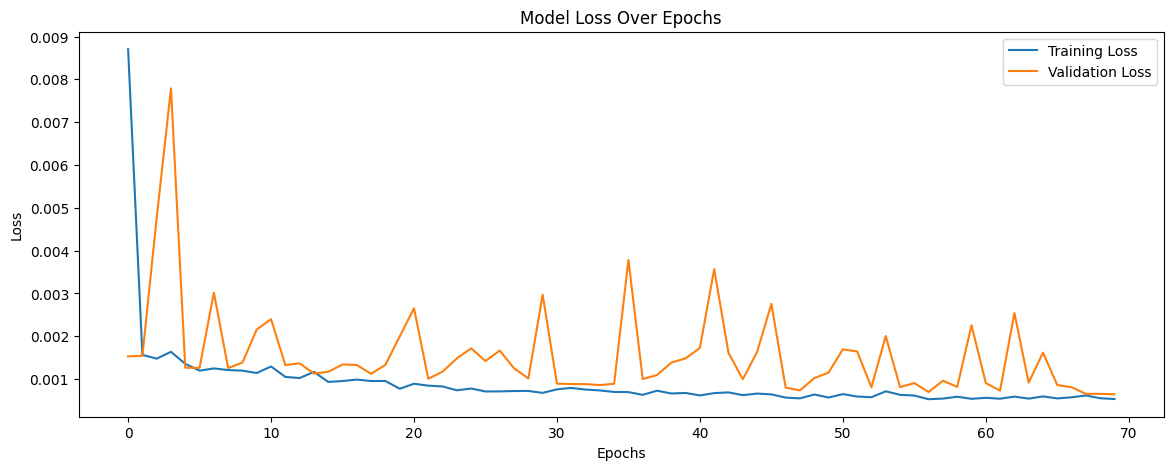

In [91]:
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Plot training vs validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


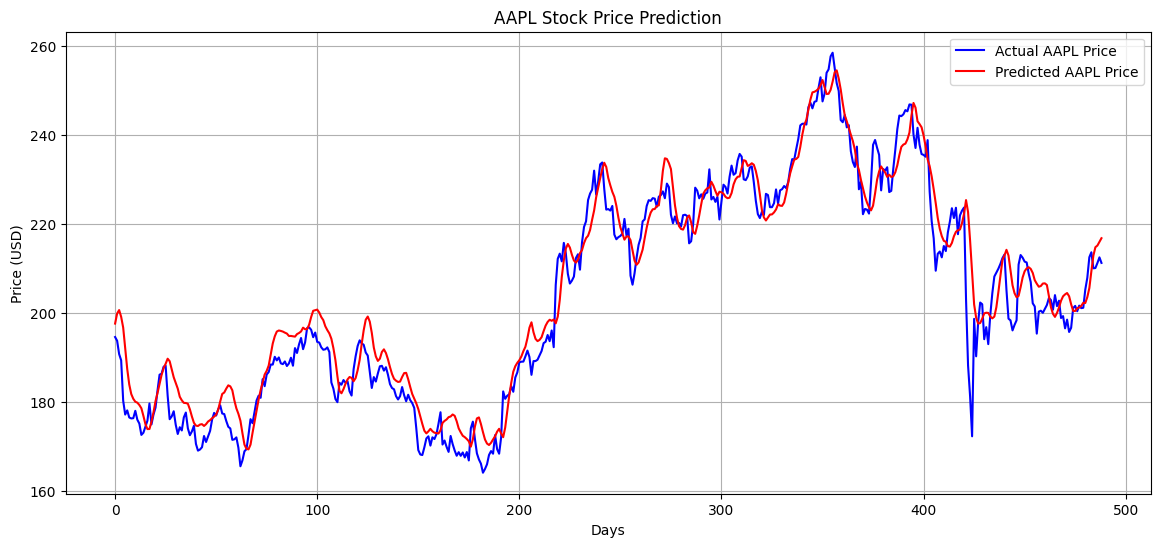

In [ ]:
# Predict using the trained model

predicted_prices = model.predict(X_test)

# Ensure both arrays are 2D and have the same number of rows
predicted_full = np.hstack((predicted_prices, np.zeros((predicted_prices.shape[0], 1))))
actual_full = np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))))

# Invert scaling
predicted_prices_actual = scaler.inverse_transform(predicted_full)[:, 0]  # only take 'Close'
actual_prices_actual = scaler.inverse_transform(actual_full)[:, 0]

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(actual_prices_actual, color='blue', label='Actual AAPL Price')
plt.plot(predicted_prices_actual, color='red', label='Predicted AAPL Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📈 Predicted closing price for the next day: $216.36


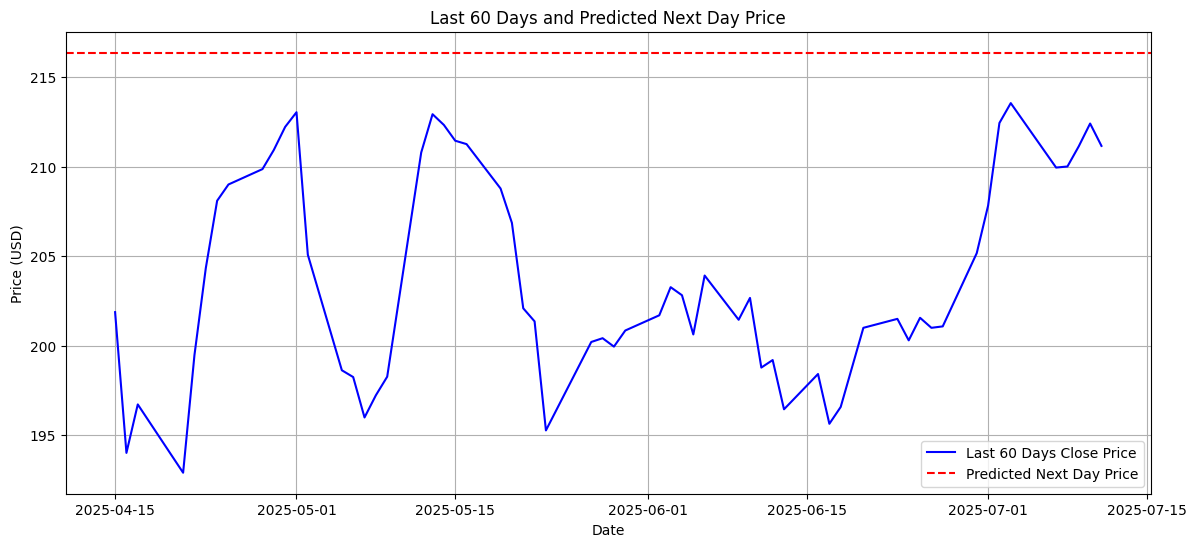

In [93]:
import numpy as np

# Step 1: Get the last 60 days from the original DataFrame (Close, RSI)
last_60_days = data[['Close', 'RSI']].values[-60:]  # shape = (60, 2)

# Step 2: Normalize using the same scaler used earlier
scaled_last_60 = scaler.transform(last_60_days)

# Step 3: Reshape to (1, 60, 2) for LSTM input
X_future = np.reshape(scaled_last_60, (1, 60, 2))

# Step 4: Predict the next day's price (scaled)
predicted_next_price = model.predict(X_future)

# Step 5: Inverse scale (with dummy RSI column)
predicted_full = np.hstack((predicted_next_price, np.zeros((predicted_next_price.shape[0], 1))))  # dummy RSI
predicted_next_price_actual = scaler.inverse_transform(predicted_full)[0][0]

# Step 6: Show predicted price
print(f"📈 Predicted closing price for the next day: ${predicted_next_price_actual:.2f}")

# Step 7: Visualize
plt.figure(figsize=(14, 6))
plt.plot(data.index[-60:], last_60_days[:, 0], label='Last 60 Days Close Price', color='blue')
plt.axhline(y=predicted_next_price_actual, color='red', linestyle='--', label='Predicted Next Day Price')
plt.title('Last 60 Days and Predicted Next Day Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Predict on the test set
predictions = model.predict(X_test)

# Step 2: Prepare 2D inputs for inverse transform (match scaler's n_features_in_)
n_features = scaler.n_features_in_
predicted_full = np.zeros((predictions.shape[0], n_features))
actual_full = np.zeros((y_test.shape[0], n_features))
predicted_full[:, 0] = predictions.flatten()  # 'Close'
actual_full[:, 0] = y_test.flatten()          # 'Close'

# Step 3: Inverse transform
predicted_prices = scaler.inverse_transform(predicted_full)[:, 0]
actual_prices = scaler.inverse_transform(actual_full)[:, 0]

# Step 4: Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Step 5: Print results
print(f"📉 Mean Absolute Error (MAE): ${mae:.2f}")
print(f"📊 Root Mean Squared Error (RMSE): ${rmse:.2f}")

# Step 6: Mean Percentage Error
percentage_error = (mae / actual_prices.mean()) * 100
print(f"📊 Mean Percentage Error: {percentage_error:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📉 Mean Absolute Error (MAE): $4.56
📊 Root Mean Squared Error (RMSE): $6.04
📊 Mean Percentage Error: 2.24%


In [95]:
model.save('model.h5')


In [96]:

import joblib
joblib.dump(scaler, 'scaler.pkl')




['scaler.pkl']